In [38]:
import os
import pandas as pd
import numpy as np
from dynaconf import LazySettings
from dynaconf.utils.boxing import DynaBox
import sklearn
import sklearn.model_selection
import sklearn.ensemble
import matplotlib.pyplot as plt
from typing import Tuple
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout

In [39]:
config_file = "C://workspaces//learning//fantasAi_football//config//conf.yaml"
config_mode = 'default'

In [40]:
params = LazySettings(settings_files=[config_file])
params = params[config_mode]

In [51]:
def filter_dataset(params: DynaBox, y_feature: str, dataset: pd.DataFrame) -> pd.DataFrame: 
    """Filter a dataset on the basis of the input parameters.
    
    Only a subset of data supports the learning of specific "y" features.

    Args:
        params (DynaBox): run parameters
        y_feature (str): the feature to learn
        dataset (pd.DataFrame): the dataset to filter

    Returns:
        pd.DataFrame: _description_
    """
    if y_feature in [
        params["FEATURES"]["AVG_VOTE"],
        params["FEATURES"]["FANTA_POINTS_RATIO"],
    ]:

        if params["FEATURES"]["AVG_VOTE"] in y_feature:
            dataset = dataset.loc[dataset[params["FEATURES"]["AVG_VOTE"]].notna()]
        elif params["FEATURES"]["FANTA_POINTS_RATIO"] in y_feature:
            dataset = dataset.loc[
                dataset[params["FEATURES"]["COMPETITION"]].isin(
                    params["SETTINGS"]["TRAINING_COMPETITIONS"]
                )
            ]
            # Defenders are not judged by their ability to score
            dataset = dataset.loc[
                dataset[params["FEATURES"]["POSITION_INDEX"]]
                >= params["SETTINGS"]["MIN_POS_IX_SCORE"]
            ]
            # To judge ability to score he must have played a minimum number 
            # of matches
            dataset = dataset.loc[
                dataset[params["FEATURES"]["MINUTES_PLAYED"]]
                > params["SETTINGS"]["MIN_MATCHES_SCORE"]
                * params["SETTINGS"]["MINUTES_PER_GAME"]
            ]
        elif y_feature == params["FEATURES"]["ON_FIELD_INDEX"]:
            dataset = dataset.loc[
                dataset[params["FEATURES"]["COMPETITION"]].isin(
                    params["SETTINGS"]["TRAINING_COMPETITIONS"]
                )
            ]

    print(f"Dataset size: {len(dataset)}")

    return dataset

In [52]:
def plot_scatter(cfs, df, y_feature, name="Feature plot"):
    """
    Function to plot a scatter matrix of dataset of features.
    
    Example of use:
    
    >>> plot_scatter(['DL', 'DS', 'DP', 'AD', 'DE', 'LD', 'FS'], df)
    
    :param df: pd.DataFrame
        dataframe with the data to plot
    :param cfs: list
        list of the names of the columns to plot
    :param y_feature: (default: params["FEATURES"]["FANTA_POINTS_RATIO"])
        the feature to predict
    :param name: str
        name of the file where scatter matrix will be saved
    """
    X = df[cfs]
    y = df[y_feature]
    scatter = pd.plotting.scatter_matrix(
        X,
        c=y,
        marker='o',
        s=40,
        hist_kwds={'bins':15},
        figsize=(20,20)
    )
    plt.suptitle('Scatter-matrix for each input variable')
    plt.savefig(name)

In [53]:
# Transfermarkt dataset
data_path = os.path.join(
    params["PATHS"]["ROOT_FOLDER"],
    f"{params['PATHS']['STAGES']['MATCHED_DATASET']}.pkl",
)
complete_dataset = pd.read_pickle(data_path)

Define the causal factors and the y feature

In [54]:
foot_features = params["FEATURES"]["FOOT"]
foot_dummy_features = [
    c for c in complete_dataset.columns if c.startswith(f"{foot_features}_")
]
cfs = [
    params["FEATURES"]["MARKET_VALUE_RATIO"],
    params["FEATURES"]["CLUB_VALUE_RATIO"],
    params["FEATURES"]["POSITION_INDEX"],
] + foot_dummy_features

y_feature = params["FEATURES"]["FANTA_POINTS_RATIO"]
# y_feature= params["FEATURES"]["ON_FIELD_INDEX"]
# y_feature = params["FEATURES"]["AVG_VOTE"]


In [56]:
dataset = filter_dataset(params, y_feature, complete_dataset)

if params["SETTINGS"]["PLOT_SCATTER"]:
    #plot_scatter(cfs, dataset[:1000], y_feature)

Dataset size: 14752


In [28]:
val_year = params["SETTINGS"]["VALIDATION_YEAR"]
t_dataset = dataset.loc[dataset["season"] != val_year]  # validation set
val_dataset = dataset.loc[dataset["season"] == val_year]

X_complete = dataset[cfs].to_numpy()
y_complete = dataset[y_feature].to_numpy()

X = t_dataset[cfs].to_numpy()
y = t_dataset[y_feature].to_numpy()
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, random_state=0
)
y_val = val_dataset[y_feature].to_numpy()
X_val = val_dataset[cfs].to_numpy()

x_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=[0, 1])
x_scaler = x_scaler.fit(X_complete)

y_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=[0, 1])
y_scaler = y_scaler.fit(y_complete.reshape(-1, 1))

X_train = x_scaler.transform(X_train)
X_test = x_scaler.transform(X_test)
X_val = x_scaler.transform(X_val)

y_train = y_scaler.transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))
y_val = y_scaler.transform(y_val.reshape(-1, 1))


In [29]:
# HINT: tried different parameters set (criterion, bootstrap off, max_depthint), with worse results.
rf = sklearn.ensemble.RandomForestRegressor(random_state=0, bootstrap=True)
rf.fit(X_train, y_train)
print(f'Accuracy on training set: {rf.score(X_train, y_train):.3f}')
print(f'Accuracy of on test set: {rf.score(X_test, y_test):.3f}')
yhat_rf=rf.predict(X_test)

C:\Users\ParrianiT\AppData\Local\Temp\ipykernel_80736\1491506462.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Accuracy on training set: 0.907
Accuracy of on test set: 0.400


In [30]:
model = Sequential()
model.add(Dense(len(cfs) * 4, kernel_initializer="normal", activation="relu"))
# model.add(Dropout(0.2))
model.add(Dense(len(cfs) * 4, kernel_initializer="normal", activation="relu"))
# model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer="normal", activation="linear"))

es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    min_delta=0.0001,
    patience=20,
    restore_best_weights=True,
)

msle = MeanSquaredLogarithmicError()
model.compile(loss=msle, optimizer="adam")

# HINT: tried with different epochs and batch_size, worse results
X_train = np.asarray(X_train).astype("float32")
y_train = np.asarray(y_train).astype("float32")
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=100,
    validation_split=0.2,
    callbacks=[es],
)


Epoch 1/100
78/78 [==============================] - 1s 4ms/step - loss: 0.0153 - val_loss: 0.0085
Epoch 2/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0060
Epoch 3/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 4/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 5/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 6/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 7/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 8/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 9/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 10/100
78/78 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0059
Epoch 11/

In [31]:
def plot_results(model, y_scaler, X_test, y_test):
    predict = pd.Series(data=y_scaler.inverse_transform(model.predict(X_test).reshape(-1, 1)).flatten())
    actuals = pd.Series(data=y_scaler.inverse_transform(y_test).flatten())
    frame = { 'PREDICT': predict, 'ACTUALS': actuals }
    results = pd.DataFrame(frame)
    results.plot.scatter(
        x='PREDICT',
        y='ACTUALS',
        c='DarkBlue')

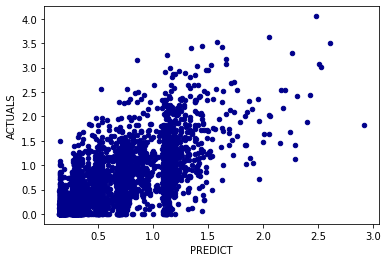

In [32]:
plot_results(model, y_scaler, X_test, y_test)

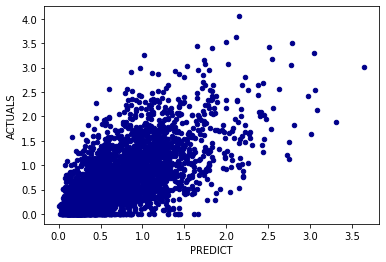

In [33]:
plot_results(rf, y_scaler, X_test, y_test)

In [34]:
# Define validation X and y
X_val = np.asarray(X_val).astype("float32")
y_val = np.asarray(y_val).astype("float32")
y_val_pred = model.predict(X_val)
y_val_pred_rf = rf.predict(X_val)
results = val_dataset.copy()
results["PRED"] = y_val_pred.flatten()
results["PRED_RF"] = y_val_pred_rf.flatten()
results["PRED_ANS"] = (results["PRED"]  + results["PRED_RF"])/2
results["APE"] = abs(results["PRED"] - results[y_feature])/results[y_feature]
results["APE_RF"] = abs(results["PRED_RF"] - results[y_feature])/results[y_feature]
results["APE_ANS"] = abs(results["PRED_ANS"] - results[y_feature])/results[y_feature]
for c in ["APE", "APE_RF", "APE_ANS"]:
    results.loc[results[c] == np.inf, c] = 1
# results = results[["APE", "APE_RF", "APE_ANS"]].fillna(0)
results[["APE", "APE_RF", "APE_ANS"]].mean()
# print(f"Mape={mape}")


APE        0.756241
APE_RF     0.752122
APE_ANS    0.752533
dtype: float64

In [35]:
results.loc[results["competition_id"] == "IT1"].sort_values(by=["PRED"], ascending=False).head(10)[['pretty_name', 'club_pretty_name', 'goals', 'assists', y_feature, 'played_matches', 'PRED', 'PRED_ANS']]

,pretty_name,club_pretty_name,goals,assists,fanta_points_ratio,played_matches,PRED,PRED_ANS
40995,Romelu Lukaku,Inter Mailand,24,10,2.478173,35,0.353230,0.454490
45548,Cristiano Ronaldo,Juventus Turin,29,2,2.857653,33,0.342882,0.376250
40892,Lautaro Martinez,Inter Mailand,17,10,2.074046,38,0.333108,0.382318
45266,Paulo Dybala,Juventus Turin,4,3,1.190476,19,0.325503,0.370105
45191,Alvaro Morata,Juventus Turin,11,10,1.91774,30,0.311222,0.362794
48729,Duvan Zapata,Atalanta Bergamo,15,10,1.994359,<NA>,0.301529,0.384558
10895,Victor Osimhen,Ssc Neapel,10,3,1.888112,24,0.300436,0.377753
17,Ciro Immobile,Lazio Rom,21,7,2.133424,35,0.299943,0.310365
48460,Luis Muriel,Atalanta Bergamo,22,9,4.610656,33,0.277784,0.368856
15779,Andrea Belotti,Fc Turin,13,7,1.387399,34,0.277551,0.277395


In [36]:
results.loc[results["competition_id"] == "IT1"].sort_values(by=[y_feature], ascending=False).head(10)[['pretty_name', 'club_pretty_name', 'goals', 'assists', y_feature, 'played_matches', 'PRED', 'PRED_ANS']]

,pretty_name,club_pretty_name,goals,assists,fanta_points_ratio,played_matches,PRED,PRED_ANS
48460,Luis Muriel,Atalanta Bergamo,22,9,4.610656,33,0.277784,0.368856
45548,Cristiano Ronaldo,Juventus Turin,29,2,2.857653,33,0.342882,0.376250
48956,Zlatan Ibrahimovic,Ac Mailand,16,2,2.835539,18,0.250501,0.330753
40995,Romelu Lukaku,Inter Mailand,24,10,2.478173,35,0.353230,0.454490
259,Felipe Caicedo,Lazio Rom,8,0,2.345277,23,0.250120,0.295369
10919,Dries Mertens,Ssc Neapel,9,11,2.196532,28,0.271413,0.295841
40885,Alexis Sanchez,Inter Mailand,7,7,2.178047,26,0.261872,0.289208
17,Ciro Immobile,Lazio Rom,21,7,2.133424,35,0.299943,0.310365
40892,Lautaro Martinez,Inter Mailand,17,10,2.074046,38,0.333108,0.382318
8278,Domenico Berardi,Us Sassuolo,17,8,2.062136,<NA>,0.176602,0.188603
